# Invasive Ductal Cancer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

In [ ]:
# Running locally
X = np.load('../idc/data/X.npy')
y = np.load('../idc/data/Y.npy')

In [3]:
# Running in Colab
X = np.load('/content/drive/MyDrive/Colab Notebooks/data/X.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/data/Y.npy')

In [4]:
X.shape

(5547, 50, 50, 3)

In [5]:
y.shape

(5547,)

## Data augmentation

In [6]:
from keras.preprocessing.image import ImageDataGenerator

X_scaled = X/255
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

# Instantiate image data generator
datagen = ImageDataGenerator(rotation_range=90, validation_split=0.3)

# Creates iterators for training images
val_images = datagen.flow(X_train, y_train, subset='validation', batch_size=32)
images = datagen.flow(X_train, y_train, subset='training', batch_size=32)

# Generates a fixed number of augmented images
# images, labels = next(datagen.flow(X_train, y_train, batch_size=X_train.shape[0]))

# # Merge original X_train with augmented images
# X_train = np.row_stack((X_train, images))
# X_train.shape
# 
# # Merge original y_train with augmented image labels
# y_train = np.hstack((y_train, labels))
# y_train.shape

## CNN Model Evaluation

In [ ]:
# Run only if you're not using data augmentation
# X_scaled = X/255
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

In [ ]:
# Final Model 1 (Based on Janowczyk and Madabhushi 2016)
# Recall:             0.849642
# Precision:          0.713426
# F1 score:           0.775599
# Balanced Accuracy:  0.751906

def init_model1(learning_rate=0.001):
  model = models.Sequential()
  model.add(layers.Conv2D(32, kernel_size=(2,2), input_shape=(50, 50, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, kernel_size=(2,2), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, kernel_size=(2,2), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(64))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(16))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))
  optimizer = Adagrad(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', Recall(thresholds=0.35), Precision(thresholds=0.35)])
 
  return model

In [33]:
# Final Model 2 (Elizabeth's version)
# Recall:             0.849642
# Precision:          0.729508
# F1 score:           0.785005
# Balanced Accuracy:  0.765207

def init_model2(learning_rate=0.001):
  model = models.Sequential()
  model.add(layers.Conv2D(100, kernel_size=(2,2), input_shape=(50, 50, 3), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(200, kernel_size=(2,2), activation="relu"))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(16))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))
  optimizer = Adagrad(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', Recall(thresholds=0.4), Precision(thresholds=0.4)])
 
  return model

In [8]:
model = init_model2()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 49, 49, 100)       1300      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 200)       80200     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 200)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 24200)             0         
                                                                 
 dense (Dense)               (None, 16)                3

In [9]:
model = init_model()
mc = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/model.{epoch:02d}-{val_loss:.2f}.h5', 
                     monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(images,
          validation_data=val_images,
          epochs=500,
          batch_size=64, 
          verbose=1,
          callbacks=mc)

Epoch 1/500
85/85 [==============================] - 12s 43ms/step - loss: 0.6904 - accuracy: 0.5243 - recall_1: 0.9949 - precision_1: 0.5063 - val_loss: 0.6901 - val_accuracy: 0.4991 - val_recall_1: 1.0000 - val_precision_1: 0.4991
Epoch 2/500
85/85 [==============================] - 3s 36ms/step - loss: 0.6855 - accuracy: 0.5460 - recall_1: 0.9795 - precision_1: 0.5076 - val_loss: 0.6822 - val_accuracy: 0.5026 - val_recall_1: 0.9845 - val_precision_1: 0.5191
Epoch 3/500
85/85 [==============================] - 3s 37ms/step - loss: 0.6778 - accuracy: 0.5865 - recall_1: 0.9620 - precision_1: 0.5185 - val_loss: 0.6734 - val_accuracy: 0.6615 - val_recall_1: 1.0000 - val_precision_1: 0.4991
Epoch 4/500
85/85 [==============================] - 3s 37ms/step - loss: 0.6717 - accuracy: 0.5971 - recall_1: 0.9540 - precision_1: 0.5273 - val_loss: 0.6670 - val_accuracy: 0.6658 - val_recall_1: 1.0000 - val_precision_1: 0.4991
Epoch 5/500
85/85 [==============================] - 3s 37ms/step - los

In [35]:
y_pred = model2.predict(X_test)
model2.evaluate(X_test, y_test)

53/53 [==============================] - 0s 4ms/step - loss: 0.5041 - accuracy: 0.7652 - recall_1: 0.8878 - precision_1: 0.6979


[0.5040940642356873,
 0.7651651501655579,
 0.8878281712532043,
 0.6979362368583679]

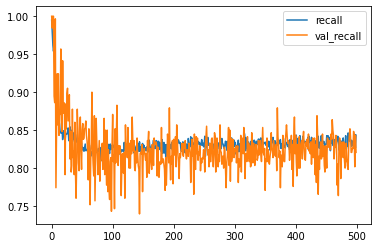

In [16]:
plt.plot(history.history['recall_1'], label='recall')
plt.plot(history.history['val_recall_1'], label='val_recall')
plt.legend()

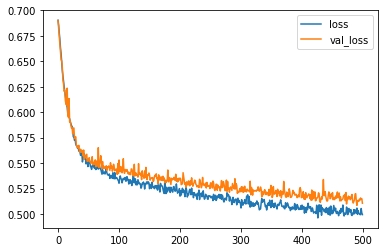

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

Precision Recall Curve

In [36]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.51035323 0.51005484 0.51036585 0.51067724 0.51098901]
recall- [1.         0.99880668 0.99880668 0.99880668 0.99880668]
threshold- [0.09811398 0.09870974 0.1003089  0.10176153 0.10179463]


In [37]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})
scores.head()

,threshold,precision,recall
0,0.098114,0.510353,1.000000
1,0.098710,0.510055,0.998807
2,0.100309,0.510366,0.998807
3,0.101762,0.510677,0.998807
4,0.101795,0.510989,0.998807


Text(0.5, 0, 'recall')

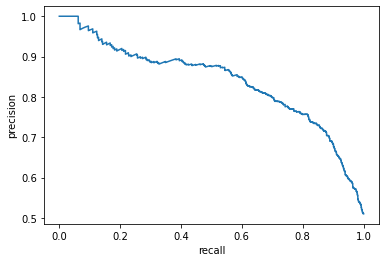

In [38]:
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [39]:
# Find threshold that guarantees 0.8 recall score
threshold = scores[scores['recall'] >= 0.85].threshold.max()
threshold

0.4640745520591736

Predict using test data

In [24]:
from sklearn.metrics import balanced_accuracy_score

In [40]:
def binary_predict(y_pred, custom_threshold=0.41):
    return (y_pred > custom_threshold).astype(int)

updated_preds = binary_predict(y_pred, custom_threshold=threshold)

print(f'Recall:             {recall_score(y_test, updated_preds)}')
print(f'Precision:          {precision_score(y_test, updated_preds)}')
print(f'F1 score:           {f1_score(y_test, updated_preds)}')
print(f'Balanced Accuracy:  {balanced_accuracy_score(y_test, updated_preds)}')

Recall:             0.8496420047732697
Precision:          0.7295081967213115
F1 score:           0.7850055126791621
Balanced Accuracy:  0.7652079431363326


Creating a report

In [ ]:
def model_diagnosis(y_pred):
    mean_prob = np.mean(y_pred)
    if mean_prob >= 0.7:
        return 'High IDC probability'
    elif mean_prob >= 0.4:
        return 'Medium IDC probability'
    else:
      return 'Low IDC probability'

In [ ]:
def generate_report(X_scaled, y_pred):
    # Remove the top 10% whitest images from predictions
    white_threshold = max([image.mean() for image in X_scaled]) * 0.90
    remove_white_mask = [image.mean() <= white_threshold for image in X_scaled]
    X_non_white = X_scaled[remove_white_mask]
    y_pred = y_pred[remove_white_mask]

    # Generate report using non-white images
    report = {}
    y_binary = binary_predict(y_pred)
    report['sum_positive'] = sum(y_binary)[0]
    report['percent_positive'] = round((report['sum_positive']/y_pred.shape[0])*100, 2)
    report['mean_probability'] = round(np.mean(y_pred)*100, 2)
    report['model_diagnosis'] = model_diagnosis(y_pred)
    return report

In [ ]:
a = generate_report(X_test, y_pred)
a

{'mean_probability': 58.4,
 'model_diagnosis': 'Medium IDC probability',
 'percent_positive': 68.14,
 'sum_positive': 586}

Save and load model

In [23]:
###################################
#   RENAME YOUR MODEL EVERY TIME  #
#     AVOID OVERWRITING MODELS    #
###################################

# From Elizabeth's Colab Notebook
model.save('/content/drive/MyDrive/Colab Notebooks/MODEL_NAME_HERE.h5')

# Local save
#model.save('../models/model2.h5')

In [34]:
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/MODEL_NAME_HERE.h5')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 49, 49, 100)       1300      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 100)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 200)       80200     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 200)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 24200)             0         
                                                                 
 dense_2 (Dense)             (None, 16)               